In [6]:
import pandas as pd
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os

### Load data and classifier

In [7]:
TEST_SKIP = True # Test on inchi keys that are not in the training set (True) or not (False). If false then testing is done on unseen data but seen inchi keys.

In [8]:
FINGERPRINTS_PATH = "./embeddings/tms_maccs_fingerprint.csv"
SPEC2VEC_PATH = "./embeddings/tms_spec2vec_embeddings.csv"


In [9]:
CLASSIFIER_FOLDER = "./models/tms_final/random_forest_per_label/"

In [10]:
classifier_data = pickle.load(open(os.path.join(CLASSIFIER_FOLDER, "models", "repeat_1_fold_1.pkl"), "rb"))

In [11]:
classifier_data

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     random_state=27082023),
                    n_jobs=-1)

In [12]:
classifier = classifier_data["classifier"]

TypeError: 'OneVsRestClassifier' object is not subscriptable

In [ ]:
y_test = classifier_data["y_test"]
y_pred = classifier.predict(classifier_data["X_test"])

### Evaluations

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)

In [ ]:
y_pred.shape, y_prob.shape, mcm.shape

((30, 166), (30, 192), (166, 2, 2))

In [ ]:
class_support = y.sum(axis=0)
class_support

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 30, 30,  0,  0,  0,  0,  0,  0,  0,  0, 30,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 30,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 30,  0, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       30,  0,  0,  0,  0,  0,  0, 30,  0,  0,  0,  0,  0, 30,  0,  0, 30,
       30,  0,  0,  0, 30,  0,  0,  0,  0, 30, 30,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 30, 30, 30, 30,  0,  0, 30,  0,  0,  0, 30,  0,  0,
        0,  0,  0,  0, 30,  0, 30,  0, 30,  0,  0, 30, 30,  0,  0, 30,  0,
        0,  0,  0, 30,  0, 30, 30,  0, 30, 30, 30, 30,  0])

In [ ]:
def TP(cm):
    return cm[1][1]

def TN(cm):
    return cm[0][0]

def FP(cm):
    return cm[0][1]

def FN(cm):
    return cm[1][0]

def precision(cm):
    return TP(cm) / (TP(cm) + FP(cm))

def recall(cm):
    return TP(cm) / (TP(cm) + FN(cm))

def specificity(cm):
    return TN(cm) / (TN(cm) + FP(cm))

def f1(cm):
    return 2 * precision(cm) * recall(cm) / (precision(cm) + recall(cm))

In [ ]:
per_class_metrics = np.empty(shape=(mcm.shape[0], 4))

for i in range(mcm.shape[0]):
    per_class_metrics[i] = [specificity(mcm[i]), recall(mcm[i]), precision(mcm[i]), f1(mcm[i])]


C:\Users\aleks\AppData\Local\Temp\ipykernel_17744\3654605282.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return TP(cm) / (TP(cm) + FN(cm))
C:\Users\aleks\AppData\Local\Temp\ipykernel_17744\3654605282.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return TP(cm) / (TP(cm) + FP(cm))
C:\Users\aleks\AppData\Local\Temp\ipykernel_17744\3654605282.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return TN(cm) / (TN(cm) + FP(cm))


In [ ]:
macro_avg = np.nanmean(per_class_metrics, axis=0)
macro_avg # Average precision, recall and f1 calculated individually for each class

array([0.98145363, 0.7989899 , 0.85294118, 0.91848085])

In [ ]:
added_mcm = np.sum(mcm, axis=0)
micro_avg = np.array([specificity(added_mcm), recall(added_mcm), precision(added_mcm), f1(added_mcm)])
micro_avg # Precision, recall and f1 calculated for all classes together

array([0.98145363, 0.7989899 , 0.91445087, 0.85283019])

In [ ]:
weighted_avg = np.empty(shape=(1, 4))
for i in range(4):
    values = per_class_metrics[:, i]
    support = class_support
    not_na_mask = ~np.isnan(values)
    if sum(support[not_na_mask]) == 0:
        weighted_avg[0, i] = np.nan
        continue
    weighted_avg[0, i] = np.average(values[not_na_mask], weights=support[not_na_mask])
weighted_avg # Precision, recall and f1 calculated for all classes together

array([[       nan, 0.7989899 , 1.        , 0.91848085]])

  0%|          | 0/192 [00:00<?, ?it/s]

Generated
Layout ready


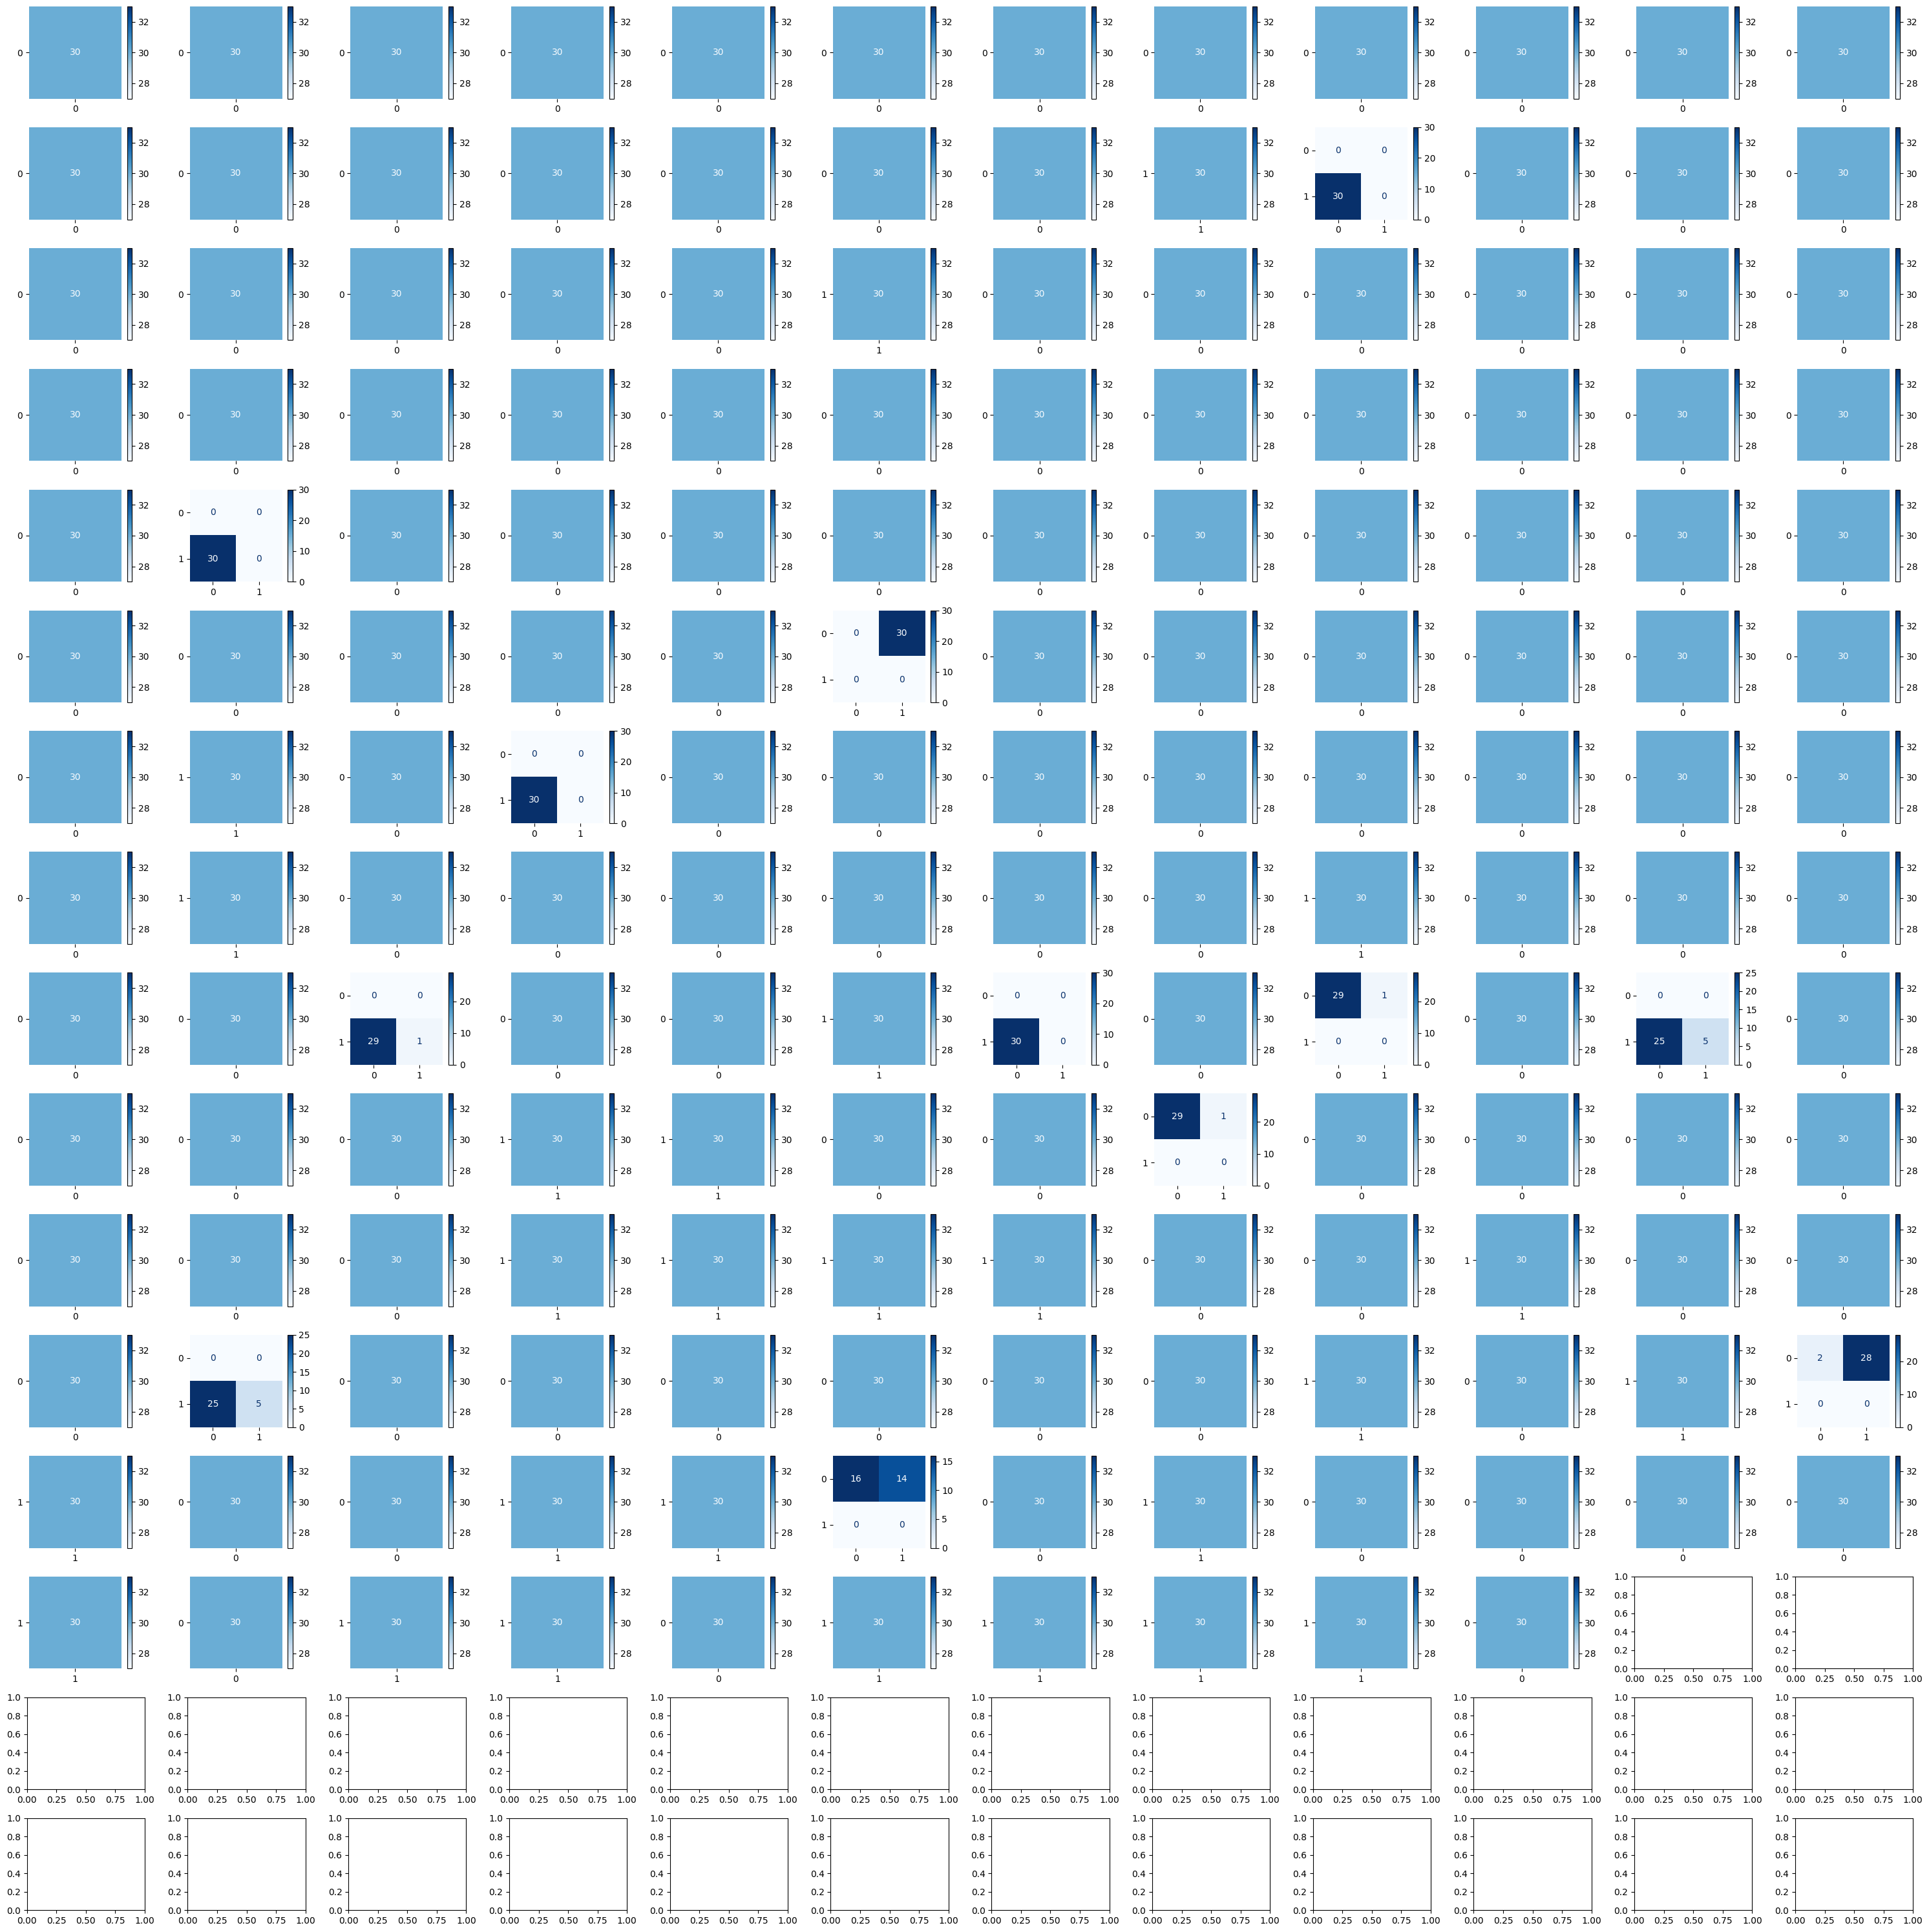

In [ ]:
fig, axes = plt.subplots(nrows=16, ncols=12, figsize=(30, 30))

for y_t, y_p, cs, ax in tqdm(zip(y.T, y_pred.T, class_support, axes.flatten()), total=192):
    ConfusionMatrixDisplay.from_predictions(y_t, 
                        y_p, 
                        ax=ax, 
                        cmap='Blues',
                        )
    # remove x and y labels
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(False)

    # outline
    strentgh = 1 - abs(cs - y.shape[0] / 2) / (y.shape[0] / 2) # higher strength for more balanced classes
    outline_color = (1, 0, 0, strentgh)

    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    ax.spines['top'].set_color(outline_color)
    ax.spines['right'].set_color(outline_color)
    ax.spines['bottom'].set_color(outline_color)
    ax.spines['left'].set_color(outline_color)

    ax.spines['top'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
print("Generated")
plt.tight_layout()
print("Layout ready")
plt.show()